In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt
from keras.optimizers import Adam

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,KFold, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Using TensorFlow backend.


In [2]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Corpus Classification")

In [3]:
df = pd.read_excel(os.getcwd()+r"\Data Files\New Categories\Corpus_Coffee.xlsx", encoding = 'unicode_escape')

In [4]:
df.head()

,spend_group,spend_cat_raw_l1,spend_cat_raw_l2,spend_cat_raw_l3,spend_cat_raw_l4,spend_cat_raw_l5,material_group_master_data,material_group_master_data_desc,material,material_desc,...,account_number,account_number_desc,cost_center,cost_center_desc,invoice_amount,invoice_amt_rep_curr_mth_rate,label_l2,label_l3,label_l4,label_l5
0,Raw,Coffee,Cof/ Arabica Green Coffee,Cof/Ara/ Washed Unclassified,Cof/Ara/ Washed Unclassified,Cof/Ara/ Washed Unclassified,R43,Coffee,43927387,Instant Coffee 103500950,...,N001/#,N001/Not assigned,0020/#,0020/Not assigned,3552.00,4044.92,Cof/ Arabica Green Coffee,Cof/Ara/ Washed Unclassified,Cof/Ara/ Washed Unclassified,Cof/Ara/ Washed Unclassified
1,Raw,Coffee,Cof/ Arabica Green Coffee,Cof/Ara/ Washed Unclassified,Not assigned,Not assigned,R43,Coffee,43444566,Coffee Green WsA Pf-ID Java,...,N001/#,N001/Not assigned,0068/#,0068/Not assigned,3399730.47,3399730.47,Cof/ Arabica Green Coffee,Cof/Ara/ Washed Unclassified,NaN,NaN
2,Raw,Coffee,Cof/ Arabica Green Coffee,Cof/Ara/ Washed Unclassified,Not assigned,Not assigned,R43,Coffee,43444566,Coffee Green WsA Pf-ID Java,...,N001/#,N001/Not assigned,0068/#,0068/Not assigned,456898.47,456898.47,Cof/ Arabica Green Coffee,Cof/Ara/ Washed Unclassified,NaN,NaN
3,Raw,Coffee,Cof/ Arabica Green Coffee,Cof/Ara/ Washed Unclassified,Not assigned,Not assigned,R43,Coffee,43444566,Coffee Green WsA Pf-ID Java,...,N001/#,N001/Not assigned,0068/#,0068/Not assigned,481257.36,481257.36,Cof/ Arabica Green Coffee,Cof/Ara/ Washed Unclassified,NaN,NaN
4,Raw,Coffee,Cof/ Arabica Green Coffee,Cof/Ara/ Washed Unclassified,Not assigned,Not assigned,R43,Coffee,43444569,Coffee Green WsA Pf-Peru,...,N001/#,N001/Not assigned,0068/#,0068/Not assigned,252424.25,252424.25,Cof/ Arabica Green Coffee,Cof/Ara/ Washed Unclassified,NaN,NaN


In [5]:
df.label_l2= np.where((df.label_l2 == 'Cof/ Roast & Ground') | (df.label_l2 == 'Cof/ Blended Green Coffee') | 
                      (df.label_l2 == 'Cof/Oil,Aroma & Extract') | (df.label_l2 == 'Cof/ Soluble')
         , "OTHERS",df.label_l2)

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df["label_l2"])
df["label_l2_enc"]=le.transform(df["label_l2"])

df["CONCATED_COLUMN"] = df["material_descr_from_po"]+" "+df["vendor_desc"]+" "+df["account_number_desc"]+" "+df["cost_center_desc"]

# df["label_l2_enc"]=pd.get_dummies(df['label_l2']).values

In [7]:
x_column = ["material_descr_from_po","vendor_desc","account_number_desc","cost_center_desc","CONCATED_COLUMN"]
y_column = ["label_l2_enc"]
seed = 10

In [8]:
df.label_l2.value_counts()

Cof/ Arabica Green Coffee    697
Cof/ Robusta Green Coffee    462
OTHERS                        25
Name: label_l2, dtype: int64

In [9]:
X_train_1, X_test, y_train_1, y_test = train_test_split(df[x_column], df[y_column], test_size=0.2, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_1, y_train_1, test_size=0.2, random_state=seed)

In [10]:
X_train.reset_index(inplace = True)
X_test.reset_index(inplace = True)
X_valid.reset_index(inplace = True)


In [11]:
print("Train sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_train.shape[0],
                                 round((y_train=="24 MRO Services").sum()/y_train.count()*100,2),
                                 round((y_train=="24 Workshop Equipment&Supplies").sum()/y_train.count()*100,2),
                                 round((y_train=="24 Industrial Gases").sum()/y_train.count()*100,2))
     )

print("valid sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_valid.shape[0],
                                 round((y_valid=="24 MRO Services").sum()/y_valid.count()*100,2),
                                 round((y_valid=="24 Workshop Equipment&Supplies").sum()/y_valid.count()*100,2),
                                 round((y_valid=="24 Industrial Gases").sum()/y_valid.count()*100,2))
     )

print("test sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_test.shape[0],
                                 round((y_test=="24 MRO Services").sum()/y_test.count()*100,2),
                                 round((y_test=="24 Workshop Equipment&Supplies").sum()/y_test.count()*100,2),
                                 round((y_test=="24 Industrial Gases").sum()/y_test.count()*100,2))
     )

Train sample : 757 	 24 MRO Services : 0.0 	 24 Workshop Equipment&Supplies : 0.0 	Industrial Gases : 0.0
valid sample : 190 	 24 MRO Services : 0.0 	 24 Workshop Equipment&Supplies : 0.0 	Industrial Gases : 0.0
test sample : 237 	 24 MRO Services : 0.0 	 24 Workshop Equipment&Supplies : 0.0 	Industrial Gases : 0.0


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

selected_col = "CONCATED_COLUMN"

sentences_train = X_train[selected_col].values
sentences_valid = X_valid[selected_col].values
sentences_test = X_test[selected_col].values

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)


maxlen = 26


X_train = X_train.merge(pd.DataFrame(pad_sequences(tokenizer.texts_to_sequences(sentences_train), padding='post', maxlen=maxlen)),left_index=True, right_index = True)
X_test = X_test.merge(pd.DataFrame(pad_sequences(tokenizer.texts_to_sequences(sentences_test), padding='post', maxlen=maxlen)),left_index=True, right_index = True)
X_valid = X_valid.merge(pd.DataFrame(pad_sequences(tokenizer.texts_to_sequences(sentences_valid), padding='post', maxlen=maxlen)),left_index=True, right_index = True)
# X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# print(sentences_train[2])
# print(X_train[2])

In [13]:
# from sklearn.feature_extraction.text import CountVectorizer

# for selected_col in x_column:
#     sentences_train = X_train[selected_col].values
#     sentences_valid = X_valid[selected_col].values
#     sentences_test = X_test[selected_col].values

#     vectorizer = CountVectorizer()
#     vectorizer.fit(sentences_train)

#     X_train = X_train.merge(pd.DataFrame(vectorizer.transform(sentences_train).toarray()),left_index=True, right_index = True)
#     X_valid = X_valid.merge(pd.DataFrame(vectorizer.transform(sentences_valid).toarray()),left_index=True, right_index = True)
#     X_test  = X_test.merge(pd.DataFrame(vectorizer.transform(sentences_test).toarray()),left_index=True, right_index = True)

In [14]:
all_col = list(X_train.columns)

In [15]:
all_col.remove('index')
all_col.remove('material_descr_from_po')
all_col.remove('vendor_desc')
all_col.remove('account_number_desc')
all_col.remove('cost_center_desc')
all_col.remove('CONCATED_COLUMN')

In [16]:
from keras.utils import to_categorical

# LSTM Model 

In [17]:
from keras.models import Sequential
from keras import layers

embedding_dim = 20

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
# model.add(layers.Flatten())
# model.add(layers.Dense(10, activation='relu'))
# model.add(layers.Dense(3, activation='sigmoid'))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 26, 20)            13180     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 26, 20)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               48400     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 61,883
Trainable params: 61,883
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=100,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=50)

In [19]:
loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9987
Valid Accuracy:  0.9895
Testing Accuracy:  0.9916


In [20]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

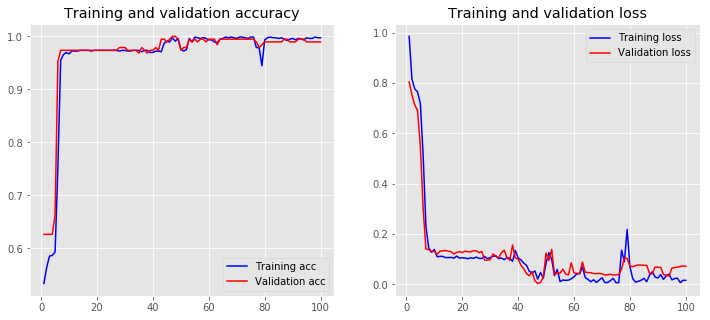

In [21]:
plot_history(history)

# Hyperparameter Tuning

In [22]:
# from keras.models import Sequential
# from keras import layers

# embedding_dim = 20

# model = Sequential()
# model.add(layers.Embedding(input_dim=vocab_size, 
#                            output_dim=embedding_dim, 
#                            input_length=maxlen))
# # model.add(layers.Flatten())
# # model.add(layers.Dense(10, activation='relu'))
# # model.add(layers.Dense(3, activation='sigmoid'))
# model.add(layers.SpatialDropout1D(0.2))
# model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(layers.Dense(3, activation='softmax'))

# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# model.summary()

In [18]:
def create_model(learning_rate=0.01, activation='relu', embedding_dim=20, n_lstm=100, dropout = 0.2, recurrent_dropout=0.2):
  
    # Create an Adam optimizer with the given learning rate
    opt = Adam(lr=learning_rate)
  
    # Create your binary classification model  
    

    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=embedding_dim, 
                               input_length=maxlen))
#     model.add(layers.Flatten())
#     model.add(layers.Dense(n_dense, activation=activation))
#     model.add(layers.Dense(3, activation='sigmoid'))

    model.add(layers.SpatialDropout1D(dropout))
    model.add(layers.LSTM(n_lstm, dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

In [24]:
params = {'activation': ["relu", "tanh"],
          'batch_size': [25, 32, 40], 
          'epochs': [10,12,15],
          'learning_rate': [0.01, 0.001, 0.0005],
          'embedding_dim' : [10,15,20,25,30],
          'n_lstm' : [50,70,100,120],
          'dropout' : [0.1,0.15,0.2,0.25,0.3], 
          'recurrent_dropout' : [0.1,0.15,0.2,0.25,0.3]
         }

In [25]:
from keras.wrappers.scikit_learn import KerasRegressor
model = KerasRegressor(build_fn = create_model,
                       verbose = 1)

In [26]:
random_search = RandomizedSearchCV(model,
                                   param_distributions = params, random_state = 10, n_iter = 20,
                                   cv = KFold(3), error_score=0, return_train_score =True)



In [27]:
print("Randomized search..")
search_time_start = time.time()
random_search.fit(X_train[all_col], to_categorical(y_train))
print("Randomized search time:", time.time() - search_time_start)

Randomized search..
Epoch 1/10
504/504 [==============================] - 1s 2ms/step - loss: 0.9549 - accuracy: 0.5655
Epoch 2/10
504/504 [==============================] - 1s 1ms/step - loss: 0.8201 - accuracy: 0.5556
Epoch 3/10
504/504 [==============================] - 1s 1ms/step - loss: 0.7933 - accuracy: 0.5813
Epoch 4/10
504/504 [==============================] - 1s 1ms/step - loss: 0.7851 - accuracy: 0.5813
Epoch 5/10
504/504 [==============================] - 1s 1ms/step - loss: 0.6042 - accuracy: 0.6627
Epoch 6/10
504/504 [==============================] - 1s 1ms/step - loss: 0.2828 - accuracy: 0.9246
Epoch 7/10
504/504 [==============================] - 1s 1ms/step - loss: 0.1377 - accuracy: 0.9663
Epoch 8/10
504/504 [==============================] - 1s 1ms/step - loss: 0.1395 - accuracy: 0.9643
Epoch 9/10
504/504 [==============================] - 1s 1ms/step - loss: 0.1260 - accuracy: 0.9663
Epoch 10/10
504/504 [==============================] - 0s 199us/step
Epoch 1/10


504/504 [==============================] - 0s 226us/step
Epoch 1/10
505/505 [==============================] - 1s 2ms/step - loss: 0.9898 - accuracy: 0.5604
Epoch 2/10
505/505 [==============================] - 0s 695us/step - loss: 0.7843 - accuracy: 0.5901
Epoch 3/10
505/505 [==============================] - 0s 800us/step - loss: 0.7594 - accuracy: 0.5881
Epoch 4/10
505/505 [==============================] - 0s 744us/step - loss: 0.7567 - accuracy: 0.5881
Epoch 5/10
505/505 [==============================] - 0s 723us/step - loss: 0.7440 - accuracy: 0.5881
Epoch 6/10
505/505 [==============================] - 0s 752us/step - loss: 0.7048 - accuracy: 0.5901
Epoch 7/10
505/505 [==============================] - 0s 763us/step - loss: 0.5236 - accuracy: 0.7386
Epoch 8/10
505/505 [==============================] - 0s 791us/step - loss: 0.2560 - accuracy: 0.9584
Epoch 9/10
505/505 [==============================] - 0s 769us/step - loss: 0.1214 - accuracy: 0.9703
Epoch 10/10
505/505 [======

504/504 [==============================] - 0s 723us/step - loss: 0.8925 - accuracy: 0.5813
Epoch 3/12
504/504 [==============================] - 0s 753us/step - loss: 0.8135 - accuracy: 0.5813
Epoch 4/12
504/504 [==============================] - 0s 728us/step - loss: 0.7884 - accuracy: 0.5813
Epoch 5/12
504/504 [==============================] - 0s 715us/step - loss: 0.7948 - accuracy: 0.5813
Epoch 6/12
504/504 [==============================] - 0s 764us/step - loss: 0.7808 - accuracy: 0.5813
Epoch 7/12
504/504 [==============================] - 0s 729us/step - loss: 0.7710 - accuracy: 0.5813
Epoch 8/12
504/504 [==============================] - 0s 742us/step - loss: 0.6659 - accuracy: 0.5833
Epoch 9/12
504/504 [==============================] - 0s 727us/step - loss: 0.5477 - accuracy: 0.7024
Epoch 10/12
504/504 [==============================] - 0s 738us/step - loss: 0.4323 - accuracy: 0.8948
Epoch 11/12
504/504 [==============================] - 0s 735us/step - loss: 0.2629 - accura

504/504 [==============================] - 0s 788us/step - loss: 0.7613 - accuracy: 0.5813
Epoch 9/12
504/504 [==============================] - 0s 794us/step - loss: 0.6487 - accuracy: 0.6131
Epoch 10/12
504/504 [==============================] - 0s 760us/step - loss: 0.5283 - accuracy: 0.7579
Epoch 11/12
504/504 [==============================] - 0s 759us/step - loss: 0.3621 - accuracy: 0.9226
Epoch 12/12
504/504 [==============================] - 0s 212us/step
Epoch 1/12
505/505 [==============================] - 1s 3ms/step - loss: 1.0273 - accuracy: 0.5723
Epoch 2/12
505/505 [==============================] - 0s 869us/step - loss: 0.7973 - accuracy: 0.5861
Epoch 3/12
505/505 [==============================] - 0s 738us/step - loss: 0.7628 - accuracy: 0.5881
Epoch 4/12
505/505 [==============================] - 0s 727us/step - loss: 0.7607 - accuracy: 0.5881
Epoch 5/12
505/505 [==============================] - 0s 740us/step - loss: 0.7618 - accuracy: 0.5881
Epoch 6/12
505/505 [====

505/505 [==============================] - 1s 1ms/step - loss: 0.1137 - accuracy: 0.9703
Epoch 10/15
505/505 [==============================] - 1s 1ms/step - loss: 0.1319 - accuracy: 0.9683
Epoch 11/15
505/505 [==============================] - 1s 1ms/step - loss: 0.1104 - accuracy: 0.9703
Epoch 12/15
505/505 [==============================] - 1s 1ms/step - loss: 0.1012 - accuracy: 0.9743
Epoch 13/15
505/505 [==============================] - 1s 1ms/step - loss: 0.0962 - accuracy: 0.9743
Epoch 14/15
505/505 [==============================] - 1s 1ms/step - loss: 0.0958 - accuracy: 0.9703
Epoch 15/15
505/505 [==============================] - 0s 228us/step
Epoch 1/15
504/504 [==============================] - 2s 4ms/step - loss: 1.0172 - accuracy: 0.5317
Epoch 2/15
504/504 [==============================] - 1s 1ms/step - loss: 0.8124 - accuracy: 0.5794
Epoch 3/15
504/504 [==============================] - 1s 1ms/step - loss: 0.7943 - accuracy: 0.5813
Epoch 4/15
504/504 [=================

505/505 [==============================] - 1s 1ms/step - loss: 0.7538 - accuracy: 0.5881
Epoch 6/12
505/505 [==============================] - 1s 1ms/step - loss: 0.7310 - accuracy: 0.5941
Epoch 7/12
505/505 [==============================] - 1s 1ms/step - loss: 0.5953 - accuracy: 0.7109
Epoch 8/12
505/505 [==============================] - 1s 1ms/step - loss: 0.3848 - accuracy: 0.9050
Epoch 9/12
505/505 [==============================] - 1s 1ms/step - loss: 0.2160 - accuracy: 0.9505
Epoch 10/12
505/505 [==============================] - 1s 1ms/step - loss: 0.1542 - accuracy: 0.9624
Epoch 11/12
505/505 [==============================] - 1s 1ms/step - loss: 0.1083 - accuracy: 0.9782
Epoch 12/12
505/505 [==============================] - 0s 241us/step
Epoch 1/12
505/505 [==============================] - 2s 4ms/step - loss: 1.0357 - accuracy: 0.3881
Epoch 2/12
505/505 [==============================] - 1s 1ms/step - loss: 0.8161 - accuracy: 0.5723
Epoch 3/12
505/505 [====================

In [28]:
print("Best Score: ",
      random_search.best_score_,
      "and Best Params: ",
      random_search.best_params_)

Best Score:  -0.14322671828953895 and Best Params:  {'recurrent_dropout': 0.1, 'n_lstm': 50, 'learning_rate': 0.01, 'epochs': 15, 'embedding_dim': 20, 'dropout': 0.2, 'batch_size': 25, 'activation': 'tanh'}


## Fit Best Model

In [19]:
model = create_model(learning_rate=0.01, activation='tanh', embedding_dim=20, n_lstm=50, dropout = 0.2, recurrent_dropout=0.1)

In [20]:
history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=100,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=40)

In [21]:
loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Valid Accuracy:  0.9947
Testing Accuracy:  0.9916


In [22]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

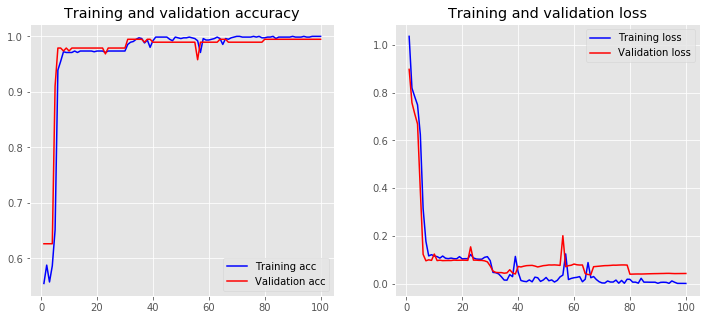

In [23]:
plot_history(history)

# Model Evaluation: Test Data

In [24]:
score, acc = model.evaluate(X_test[all_col], to_categorical(y_test),
                       batch_size=16, verbose=2)

print('Test accuracy:', acc)

Test accuracy: 0.9915611743927002


Confusion matrix, without normalization


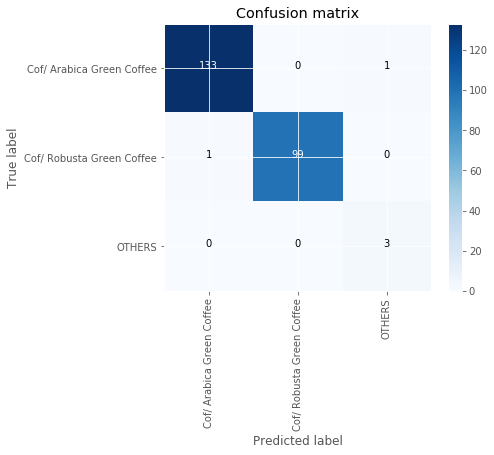

In [25]:
text_labels = le.classes_
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = pd.DataFrame(model.predict_classes(X_test[all_col]));
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(text_labels), normalize=False,
                      title='Confusion matrix')

fig.savefig("txt_classification_NN_BOW" + ".png", pad_inches=5.0)


In [26]:
from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(y_test, y_pred)
cohen_score

0.98325147521289

In [27]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, y_pred)


score_dic= {'Labels':text_labels,
           'precision':precision,
            'recall':recall,
            'fscore':fscore,
            'support':support
           }

pd.DataFrame(score_dic)


,Labels,precision,recall,fscore,support
0,Cof/ Arabica Green Coffee,0.992537,0.992537,0.992537,134
1,Cof/ Robusta Green Coffee,1.000000,0.990000,0.994975,100
2,OTHERS,0.750000,1.000000,0.857143,3


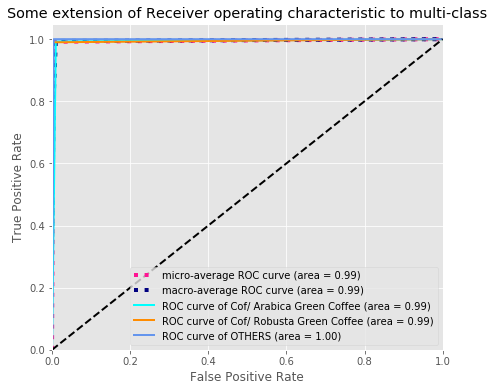

In [28]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

num_labels = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve((y_test==i), (y_pred == i))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_labels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_labels):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
# plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(text_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [29]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_labels):
    precision[i], recall[i], _ = precision_recall_curve((y_test==i), (y_pred == i))
    average_precision[i] = average_precision_score((y_test==i), (y_pred == i))

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
average_precision["micro"] = average_precision_score(to_categorical(y_test), to_categorical(y_pred),
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.99


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.99')

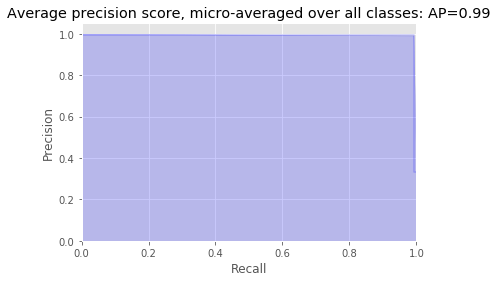

In [30]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

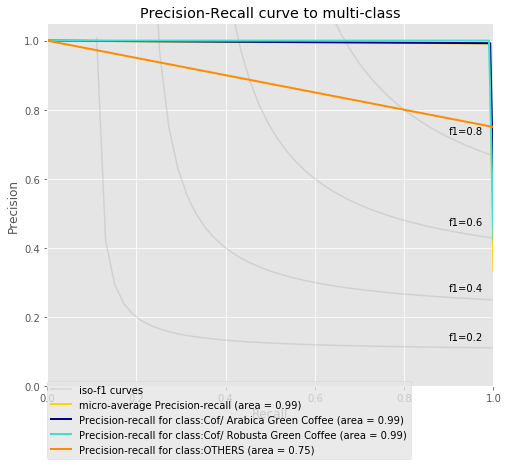

In [31]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(8, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(num_labels), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(text_labels[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))


plt.show()